# Model Evaluation

This tutorial steps through the model evaluation process for the case of the baseline ensemble MC dropout.


In [1]:
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from tabulate import tabulate
import torch

print("Torch  Version", torch.__version__)

Torch  Version 1.12.0+cu102


In [2]:
from vpower.src.utils.auxiliary_functions import *
from vpower.src.utils.assessment import calc_uncertainty_regection_curve, f_beta_metrics, get_model_errors, get_performance_metric
from vpower.src.utils.uncertainty import ensemble_uncertainties_regression
from vpower.src.utils.plot_utils import get_comparison_error_retention_plot, get_comparison_f1_retention_plot
from vpower.src.models.mc_dropout import *

In [3]:
# Optional: Customize the plots configuration
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('figure', titlesize=30)

# Directories to be used

This tutorial assumes that
* all data files are in a local directory named `datasets`.
* the trained models and train statistics for data scaling are in a local folder named `baselines`.

In [4]:
data_dir = "datasets"
model_dir = "baselines"

# Load data

In [5]:
# Load data partitions and assign them to dictionary data_all
data_all = {}

for partition in ["train", "dev_in", "dev_out"]:
    df = load_data_and_set_index(filepath=os.path.join(data_dir, f"{partition}.csv"), index_column_name="time_id")
    data_all[partition] = df

data_all["dev"] = pd.concat([data_all["dev_in"], data_all["dev_out"]])

In [6]:
print("Number of records per dataset type:" + "\n")
for k in data_all.keys():
    print(f"{k}: ", data_all[k].shape[0])

Number of records per dataset type:

train:  523190
dev_in:  18108
dev_out:  18108
dev:  36216


# Data scaling

In [7]:
input_features = ["draft_aft_telegram",
                  "draft_fore_telegram",

                  "stw",
                  "diff_speed_overground",

                  "awind_vcomp_provider",
                  "awind_ucomp_provider",
                  "rcurrent_vcomp",
                  "rcurrent_ucomp",
                  "comb_wind_swell_wave_height",

                  "timeSinceDryDock",
                  ]

target = "power"

In [8]:
# Load statistics for data scaling
filepath = os.path.join(model_dir, 'stats')

with open(os.path.join(filepath, 'means.json'), 'r') as f:
    means = pd.Series(json.load(f))
with open(os.path.join(filepath, 'stds.json'), 'r') as f:
    stds = pd.Series(json.load(f))

In [9]:
data_all_norm = {}
for k in data_all.keys():
    data_all_norm[k] = data_normalization(data=data_all[k], means=means, stds=stds)

In [10]:
data_all_norm['train'].describe()

,awind_ucomp_provider,awind_vcomp_provider,comb_wind_swell_wave_height,diff_speed_overground,draft_aft_telegram,draft_fore_telegram,power,rcurrent_ucomp,rcurrent_vcomp,stw,timeSinceDryDock
count,5.231900e+05,5.231900e+05,5.231900e+05,5.231900e+05,5.231900e+05,5.231900e+05,5.231900e+05,5.231900e+05,5.231900e+05,5.231900e+05,523190.000000
mean,-1.508031e-16,-2.503244e-16,1.373308e-16,-2.585817e-17,1.964351e-15,1.043018e-17,1.894817e-16,-6.518865e-18,-4.345910e-18,1.324633e-15,0.226110
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.105390
min,-1.609081e+00,-3.310021e+00,-2.232109e+00,-8.232534e+00,-3.446784e+00,-3.433145e+00,-2.426341e+00,-5.882673e+00,-4.390627e+00,-4.405004e+00,0.002492
25%,-8.116068e-01,-7.564000e-01,-6.934100e-01,-6.196748e-01,-7.911742e-01,-7.115869e-01,-8.845777e-01,-4.522424e-01,-4.175400e-01,-7.257049e-01,0.154468
50%,-2.453545e-01,-1.782838e-02,-1.144700e-01,-1.413945e-03,2.027145e-01,1.915621e-01,1.926598e-01,-1.786759e-02,1.458298e-02,3.610918e-01,0.239873
75%,6.358525e-01,7.451101e-01,5.606564e-01,6.174625e-01,7.546046e-01,7.928354e-01,7.263591e-01,4.341876e-01,4.191766e-01,6.765600e-01,0.314985
max,3.124058e+00,2.792529e+00,4.615205e+00,8.767026e+00,1.991983e+00,2.053773e+00,2.944730e+00,5.925018e+00,4.435618e+00,2.322942e+00,0.401345


# Load models

The provided baseline is an ensemble MC dropout consisting of 10 probabilistic MC dropout neural networks that have the same structure but trained with different parameters' initialization.

In [11]:
loaded_models = []

for i in range(1, 11):
    model = ProbMCdropoutDNN(input_size=len(input_features),
                             hidden_size_1=50,
                             hidden_size_2=20,
                             dropout=0.005)
    load_path = os.path.join(model_dir, f"member_{i}", "best_model.pth")
    model.load_state_dict(torch.load(load_path))
    loaded_models.append(model)

During inference, each member of the ensemble is sampled 10 times (multi_runs=10) to capture the epistemic uncertainty due to the stochasticity of the single model’s parameters).

In [12]:
predictions = {}

for k in data_all.keys():
    predictions[k] = {}
    inputs = torch.tensor(data_all_norm[k][input_features].values).float()
    preds_norm = get_ensemble_predictions(model_list=loaded_models,
                                          data_norm=inputs,
                                          multi_runs=10)
    predictions[k]["norm"] = preds_norm

    # Denormalize predicted mean
    preds_denorm = denorm_prediction(preds_norm=preds_norm,
                                     target_mean=means[target],
                                     target_std=stds[target])
    predictions[k]["denorm"] = preds_denorm

100%|██████████| 10/10 [00:01<00:00,  5.96it/s]


In [13]:
uncertainties = {}
for k in data_all.keys():
    uncertainties[k] = ensemble_uncertainties_regression(preds=predictions[k]["denorm"])

In [14]:
sqr_errors = {}
for k in data_all.keys():
    ens_predictions = np.squeeze(np.mean(predictions[k]["denorm"][:, :, 0], axis=0))
    power_labels = np.asarray(data_all[k][target])
    sqr_errors[k] = get_model_errors(y_pred=ens_predictions, y_true=power_labels)

### MSE retention values

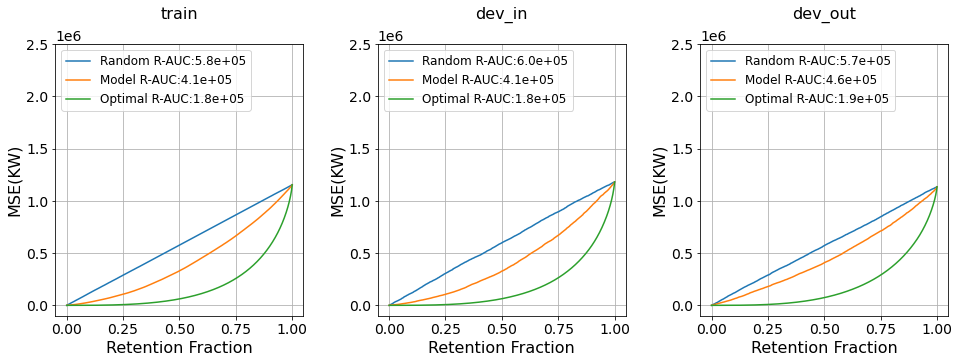

In [15]:
plt.figure(figsize=(16, 5))
plt.subplots_adjust(wspace=.3, hspace=.4)

for i, partition in enumerate(["train", "dev_in", "dev_out"]):
    plt.subplot(1, 3, i + 1)
    get_comparison_error_retention_plot(error=sqr_errors[partition],
                                        uncertainty=uncertainties[partition]["tvar"])
    plt.ylabel('MSE(KW)')
    plt.xlabel("Retention Fraction")
    plt.legend(loc="upper left", prop={"size": 12})
    plt.title(partition, pad=25)
    plt.ylim(-0.1e6, 2.5e6)
    plt.grid()

plt.show()
plt.close()

# F1 retention curves

#### Define threshold of acceptable errors

In [16]:
# Use an acceptable error threshold of (500 kW)^2
thresh = 500 ** 2

#### Plot F1 retentions

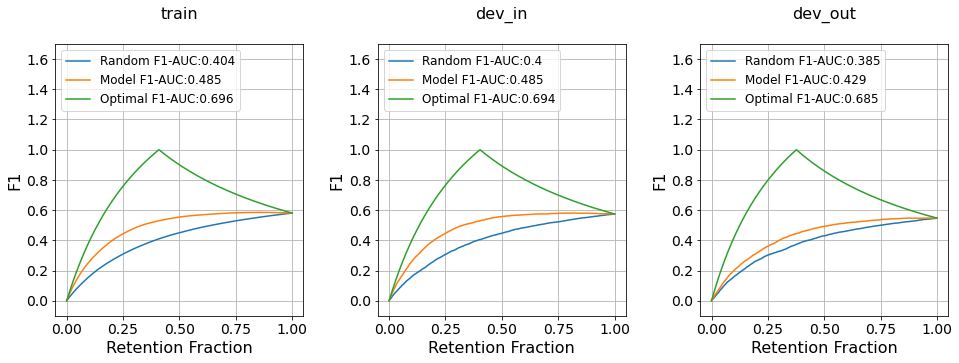

In [17]:
plt.figure(figsize=(16, 5))
plt.subplots_adjust(wspace=.3, hspace=.4)

for i, partition in enumerate(["train", "dev_in", "dev_out"]):
    plt.subplot(1, 3, i + 1)
    get_comparison_f1_retention_plot(error=sqr_errors[partition],
                                     uncertainty=uncertainties[partition]["tvar"],
                                     threshold=thresh)
    plt.legend(loc="upper left", prop={"size": 12})
    plt.ylabel('F1')
    plt.xlabel("Retention Fraction")
    plt.title(partition, pad=25)
    plt.ylim(-0.1, 1.7)
    plt.grid()

plt.show()
plt.close()

# Predictive performance Tables

In [18]:
table = [["Data", "RMSE Ens. (KW)", "MAE Ens. (KW)", "MAPE (%)"]]

for k in data_all.keys():
    ens_predictions = np.squeeze(np.mean(predictions[k]["denorm"][:, :, 0], axis=0))
    rmse_metric = get_performance_metric(y_pred=ens_predictions, y_true=data_all[k][target], metric="rmse")
    mae_metric = get_performance_metric(y_pred=ens_predictions, y_true=data_all[k][target], metric="mae")
    mape_metric = get_performance_metric(y_pred=ens_predictions, y_true=data_all[k][target], metric="mape")

    results = [k,
               np.round(rmse_metric, 0),
               np.round(mae_metric, 0),
               np.round(100 * mape_metric, 2)]
    table.append(results)

print("Classic metrics")
print(tabulate(table, headers="firstrow", tablefmt="fancy_grid"))

Classic metrics
╒═════════╤══════════════════╤═════════════════╤════════════╕
│ Data    │   RMSE Ens. (KW) │   MAE Ens. (KW) │   MAPE (%) │
╞═════════╪══════════════════╪═════════════════╪════════════╡
│ train   │             1074 │             817 │       6.47 │
├─────────┼──────────────────┼─────────────────┼────────────┤
│ dev_in  │             1087 │             827 │       6.18 │
├─────────┼──────────────────┼─────────────────┼────────────┤
│ dev_out │             1065 │             834 │       7.5  │
├─────────┼──────────────────┼─────────────────┼────────────┤
│ dev     │             1076 │             830 │       6.84 │
╘═════════╧══════════════════╧═════════════════╧════════════╛


In [19]:
table = [["Data", "R-AUC", "F1-AUC", "F1 @ 95 %"]]

for k in data_all.keys():
    r = sqr_errors[k]
    var = uncertainties[k]["tvar"]

    rejection_mse = calc_uncertainty_regection_curve(errors=r, uncertainty=var, group_by_uncertainty=False)
    retention_mse = rejection_mse[::-1]
    retention_fractions = np.linspace(0, 1, len(retention_mse))
    roc_auc = auc(x=retention_fractions[::-1], y=retention_mse)

    f_auc, f95, retention_f1 = f_beta_metrics(errors=r,
                                              uncertainty=var,
                                              threshold=thresh,
                                              beta=1.0)
    results = [k,
               roc_auc,
               np.round(f_auc, 3),
               np.round(f95, 3)]
    table.append(results)

print("AUCs")
print(tabulate(table, headers="firstrow", tablefmt="fancy_grid"))

AUCs
╒═════════╤═════════╤══════════╤═════════════╕
│ Data    │   R-AUC │   F1-AUC │   F1 @ 95 % │
╞═════════╪═════════╪══════════╪═════════════╡
│ train   │  407604 │    0.485 │       0.583 │
├─────────┼─────────┼──────────┼─────────────┤
│ dev_in  │  413260 │    0.485 │       0.576 │
├─────────┼─────────┼──────────┼─────────────┤
│ dev_out │  457387 │    0.429 │       0.547 │
├─────────┼─────────┼──────────┼─────────────┤
│ dev     │  434034 │    0.459 │       0.563 │
╘═════════╧═════════╧══════════╧═════════════╛
